# Qolor Qoding

Am Anfang müssen wir wieder ein paar Funktionen importieren, die wir verwenden wollen. Dafür musst Du die folgende Zelle einfach nur ausführen.

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from copy import copy
from utils import load_image, reduce_rgb_values, print_mapping, create_rgb_qubits
from ipywidgets import interact, interact_manual, interactive

Jetzt kommt noch etwas wichtiges zu Beginn: Hier müssen wir schon festlegen, wie viele Qubits wir verwenden wollen. Du kannst einen Wert zwischen `2` und `8` wählen. Aber fangen wir erstmal mit `2` an, diesen Wert kannst du später noch ändern. 

In [2]:
qubits = widgets.IntSlider(min=0, max=8, value=2, description="Qubit Anzahl")

[Hier](./Image_Basics.ipynb) findest du übrigens die Grundlagen zur Bildverarbeitung falls du nochmal etwas nachschauen möchtest.

## Bild laden

Zunächst müssen wir das Bild wieder laden. Das geht genauso wie eben. Auch die Größe lassen wir uns wieder anzeigen.

Das Bild hat folgende Dimensionen: (512, 512, 3)


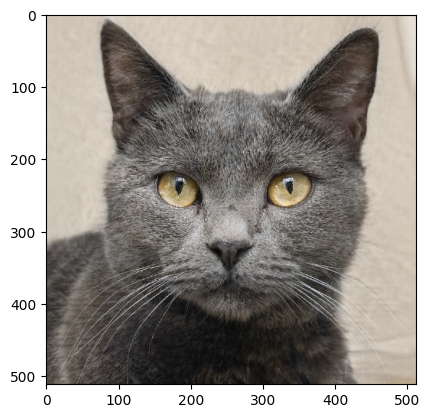

In [3]:
cat_path = "./images/Cat.jpg"
original_image = load_image(cat_path)
print("Das Bild hat folgende Dimensionen:", original_image.shape)

plt.imshow(original_image)

## Werte reduzieren

Jetzt wird es ein wenig kompliziert. Farbwerte können Werte zwischen `0` und `255` annehmen. Ein Computer benötigt dafür genau `8 Bit` - also 8 Werte, die Null oder Eins sind. 

Diese acht Werte kriegen wir heute schon locker auf einen Quantencomputer, aber weniger wäre trotzdem besser. Denn weniger Werte bedeuten immer weniger Rechenaufwand - auf normalen Computern und auf Quantencomputern. 

Was und wie macht das der folgende Code Block? Hierfür ein kleines Beispiel. 

Stell dir vor, du willst einer Freundin eine zweistellige Zahl übermitteln, also zB. `63`. Dafür darfst du ihr aber nur eine einstellige Zahl mitteilen. Wie könntest du das machen? 

Nun - perfekt geht das nicht. Man kann nicht eine Nachricht schicken, die mehr Infos hat als Stellen. Man kann aber nah drankommen. Du könntest deine Zahl zum Beispiel auf die nächste Zehnerstelle runden und deiner Freundin dann die Zehnerstelle nennen, also `63` runden auf `60` und deiner Freundin dann die `6` nennen. Diese müsste dann `6` mit `10` multiplizieren und wüsste: "Die Zahl war ungefähr 60". 
Das ist natürlich nicht perfekt. Informationen gehen verloren, aber statt 2 Ziffern musst du nur eine übergeben - stell dir das mal in einem ganz großen Stil vor. 

Genau das macht die folgenden Funktion nur eben auf Basis von Bits. So sparen wir für jeden Pixelwert etliche Ziffern bzw. Bits - das sind Millionen für ein ganzes Bild! 

Führe die folgende Zelle einfach nur aus. Das Bild wird nach dieser Reduzierung ein bisschen anders aussehen, denn auch hier gehen ja Informationen und damit Details verloren. Wenn du das ganze noch besser verstehen willst, frag uns einfach :)

Wenn du ganz oben mehr qubits angegeben hast, gehen weniger Infos verloren, weil wir erlauben mehr zu übergeben. Bei `8` Qubits gibt es keinen Informationsverlust, dann dauert die Bildbearbeitung aber lange. 

In [4]:
image = None


def reduce_values(qubits):
    global image
    image = reduce_rgb_values(original_image, qubits)
    plt.imshow(image)
    plt.show()
    return


interact(reduce_values, qubits=qubits);

interactive(children=(IntSlider(value=2, description='Qubit Anzahl', max=8), Output()), _dom_classes=('widget-…

## Bildteile auswählen 

Wir können natürlich alle Pixel auf dem Quanten Computer bearbeiten lassen. Aber es kann auch cool aussehen nur Teile des Bildes umformen zu lassen. 

Im Folgenden erstellen wir dafür eine Liste, die alle Pixel Positionen beinhalten soll, die transformiert werden sollen. Wir nenne sie `pixels_to_transform`. Die Position eines Pixels wird auch wieder eine Liste mit seinen beiden Werten für Zeile und Spalte - also zB.: `[312, 250]`

Schreiben wir erstmal alle Pixel hinein. 

In [5]:
# Zunächst ist die Liste leer
pixels_to_transform = []

# jetzt fügen wir wieder mit zwei for Schleifen alle Pixel hinzu

for row in range(original_image.shape[0]):
    for column in range(original_image.shape[1]):
        # jetzt fügen wir die aktuelle Position als Liste hinzu.
        pixel = [row, column]
        pixels_to_transform.append(pixel)

print("Finale Länge von 'pixels_to_transform'", len(pixels_to_transform))
print(original_image.shape)

Finale Länge von 'pixels_to_transform' 262144
(512, 512, 3)


Da wir alle Pixel hinzugefügt haben, ist die Länge der Liste genau `Zeilen * Spalten` des Bildes. 

### Ein Rechteck auswählen

Um nur ein Rechteck zu verändern müssen wir die Position des oberen linken Pixels kennen und die Position des Pixels unten rechts. Alle Pixel, die dazwischen liegen gehören zum Rechteck dazu. 

Um das ganze umzusetzen, müssen wir aber noch etwas neues lernen zu der `range()` Funktion, die wir schon kennen. Wenn wir `range(5)` schreiben, erhalten wir ja `[0, 1, 2, 3, 4]`. Die Liste beginnt also bei `0` und der Wert, den wir angegeben haben, ist die obere Grenze. Man kann aber auch zwei Werte an `range()` übergeben. Dann ist der erste die untere Grenze und der zweite die obere:

In [6]:
for i in range(3, 7):
    print(i)

3
4
5
6


`range(5)` ist also genau das gleiche wie `range(0, 5)`. Führe die letzte Zelle gerne mehrmals mit unterschiedlichen Werten aus, um es besser zu verstehen. 

Mit diese Wissen können wir jetzt unseren Code von oben anpassen, um nur einen Teil des Bildes auszuwählen. Achte besonders darauf, wie sich die Übergabewerte von `range()` geändert haben. 

Vorher müssen wir aber natürlich festlegen, von wo nach wo unser Rechteck gehen soll. Dafür nutzen wir zwei Listen, die jeweils Zeile und Spalte der Pixel beinhalten. Kann man auch als x Wert und y Wert von zwei Punkten sehen - wie im Matheunterricht. 

Du musst natürlich darauf achten, dass die Punkte nicht außerhalb des Bildes liegen. Wir gucken uns in der Code Zelle vorher nochmal an, wie das Bild aussieht. Die Achsen können dir helfen ein Rechteck auszuwählen.

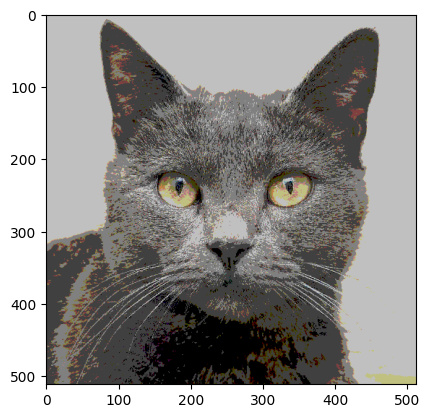

In [7]:
plt.imshow(image)
plt.show()

In [119]:
left_x = widgets.IntSlider(
    min=0, max=image.shape[0], value=200, description="Oben links (x)"
)
left_y = widgets.IntSlider(
    min=0, max=image.shape[1], value=30, description="Oben links (y)"
)
bottom_x = widgets.IntSlider(
    min=0, max=image.shape[0], value=500, description="Unten rights (x)"
)
bottom_y = widgets.IntSlider(
    min=0, max=image.shape[1], value=330, description="Unten rechts (y)"
)


def x_value_changed(change):
    if change.owner == left_x:
        bottom_x.min = change.new
        if bottom_x.value <= change.new:
            bottom_x.value = change.new
    else:
        left_x.max = change.new
        if left_x.value >= change.new:
            left_x.value = change.new
    show_rectangular_selection(
        left_x.value, left_y.value, bottom_x.value, bottom_y.value
    )


def y_value_changed(change):
    if change.owner == left_y:
        bottom_y.min = change.new
        if bottom_y.value <= change.new:
            bottom_y.value = change.new
    else:
        left_y.max = change.new
        if left_y.value >= change.new:
            left_y.value = change.new
    show_rectangular_selection(
        left_x.value, left_y.value, bottom_x.value, bottom_y.value
    )


left_x.observe(x_value_changed, "value")
left_y.observe(y_value_changed, "value")
bottom_x.observe(x_value_changed, "value")
bottom_y.observe(y_value_changed, "value")
# bottom_x.observe()

left_box = widgets.HBox([left_x, left_y])
bottom_box = widgets.HBox([bottom_x, bottom_y])
out_box = widgets.Output()
out_box.layout.height = "440px"
widgets.VBox([left_box, bottom_box, out_box])

In [118]:
def show_rectangular_selection(left_x, left_y, bottom_x, bottom_y):
    # wir starten wieder mit einer leeren Liste
    pixels_to_transform = []

    # wir definieren das Rechteck
    for row in range(left_y, bottom_y):
        for column in range(left_x, bottom_x):
            pixel = [row, column]
            pixels_to_transform.append(pixel)

    image_copy = copy(image)

    for pixel in pixels_to_transform:
        row = pixel[0]
        column = pixel[1]

        image_copy[row, column, 0] = 255  # R
        image_copy[row, column, 1] = 255  # G
        image_copy[row, column, 2] = 255  # B

    with out_box:
        plt.imshow(image_copy)
        out_box.clear_output()
        plt.show()

In [19]:
# wir starten wieder mit einer leeren Liste
pixels_to_transform = []


def show_rectangular_selection(left_x, left_y, bottom_x, bottom_y):
    global pixels_to_transform
    # wir starten wieder mit einer leeren Liste
    pixels_to_transform = []

    # wir definieren das Rechteck
    for row in range(left_y, bottom_y):
        for column in range(left_x, bottom_x):
            pixel = [row, column]
            pixels_to_transform.append(pixel)

    image_copy = copy(image)

    for pixel in pixels_to_transform:
        row = pixel[0]
        column = pixel[1]

        image_copy[row, column, 0] = 255  # R
        image_copy[row, column, 1] = 255  # G
        image_copy[row, column, 2] = 255  # B

    plt.imshow(image_copy)
    plt.show()


rect = interactive(
    show_rectangular_selection,
    left_x=widgets.IntSlider(
        min=0, max=image.shape[0], value=200, description="Links (x)"
    ),
    left_y=widgets.IntSlider(
        min=0, max=image.shape[1], value=30, description="Links (y)"
    ),
    bottom_x=widgets.IntSlider(
        min=0, max=image.shape[0], value=500, description="Rechts (x)"
    ),
    bottom_y=widgets.IntSlider(
        min=0, max=image.shape[1], value=330, description="Rechts (y)"
    ),
);

Markiere dir einen Bereich auf dem Bild, den du hinterher gern mit Hilfe eines Quantencomputers verändern möchte. Benutze dazu die dargestellten Slider und schaue dir an, wie sich das weiße Rechteck verändert. Wenn du zufrieden mit deiner Wahl bist, gehe einfach weiter im Text.

In [20]:
left_x = rect.children[0]
left_y = rect.children[1]
bottom_x = rect.children[2]
bottom_y = rect.children[3]
left_box = widgets.HBox([left_x, left_y])
bottom_box = widgets.HBox([bottom_x, bottom_y])
widgets.VBox([left_box, bottom_box, rect.children[4]])

Spiele damit gerne ein wenig herum. Das Rechteck kannst du beliebig wählen. Wenn du das gesamt Bild willst, führe einfach die entsprechende Zelle nochmal aus (die erste Code-Zelle im Abschnitt "Bildteile auswählen"). 

Die letzte Codezeile kannst du immer nochmal ausführen, um Dir anzeigen zu lasenn, was transformiert wird. 

## Los geht's mit Quanten!

Hier brauchen wir als erstes ganz viele Imports. Quanten Computer sind kompliziert ;)
Führe die folgende Zelle einfach nur aus.

In [10]:
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.circuit.random import random_circuit
from qiskit.providers.fake_provider import FakeManilaV2, FakeBoeblingen, FakeMelbourne
from utils import (
    filling_zeros,
    create_mapping,
    convert_image,
    convert_rgb_image,
    get_result,
    create_rgb_mapping,
)

Ein wesentlicher Bestandteil zum Bedienen von den Quantencomputern wie wir sie heute verwenden möchten, ist die Definition des Quanten-Schaltkreises (Quantum Circuit).
Dieses gibt an, wie die Information auf dem Quantencomputer verarbeitet werden. Du kannst Dir das so ein bisschen vorstellen wie die einfachen Operation im allerersten Notebook heute, in dem wir pro Zeile den Wert einer Variable verändert haben.
Im dem Fall hier, wäre ein Qubit die Variable und jede Operation (jedes Gate) das wir darauf anwenden verändert diese Variable.

Lass uns mal ein ganz einfaches Beispiel machen. Wir erstellen uns ein Circuit mit nur einem einzigen Qubit. Ein Qubit ist zu Beginn immer im Zustand `0`, wir wollen es jetzt in den Zustand `1` ändern. 
Das funktioniert mit einem sogenannten `x` Gate erreichen, das wir einfach auf `quantum_circuit` aufrufen. Führe die folgende Zelle mal aus. Mit der Funktion `draw()` können wir uns noch zeichnen lassen, wie das Circuit dann aussieht. 

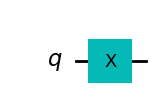

In [11]:
# Wir erstellen unser Circuit. Das soll 1 Qubit haben
quantum_circuit = QuantumCircuit(1)

# Wir fügen das x Gate auf Qubit 0 hinzu
# (wir fangen wieder bei 0 an zu zählen)
quantum_circuit.x(0)
quantum_circuit.draw("mpl")

Super Sache! Aber woher wissen wir denn nun ob das Qubit wirklich verändert wurde?
Nun dazu müssen wir es messen. Das geschieht durch anhängen eines Messoperators. Dieser macht aus dem Qubit-Zustand wieder `0` oder `1`. Wir können allgemein beliebig viele Qubits messen, indem wir `measure_all()` auf dem Circuit aufrufen.

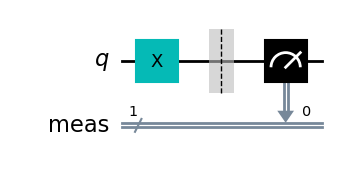

In [13]:
quantum_circuit = QuantumCircuit(1)
quantum_circuit.x(0)
quantum_circuit.measure_all()
quantum_circuit.draw("mpl")

Jetzt müssen wir das ganze einmal ausführen und können uns das Ergebnis direkt anzeigen lassen.

In [14]:
result = get_result(quantum_circuit)

print(result)

{'1': 100}


In [64]:
quantum_circuit = None
def process_image(option):
    global quantum_circuit
    if option == "Invertierte Katze":
        quantum_circuit = QuantumCircuit(qubits.value)
        for i in range(qubits.value):
            quantum_circuit.x(i)
        mapping = create_mapping(quantum_circuit)
        q_image = convert_image(qubits.value, image, mapping, pixels_to_transform)
    elif option == "Vertauschte Katze":
        rgb_qubits = create_rgb_qubits(qubits.value)
        quantum_circuit = QuantumCircuit(*rgb_qubits)
        quantum_circuit.swap(0, 3)
        quantum_circuit.swap(1, 4)
        quantum_circuit.swap(2, 5)
        mapping = create_rgb_mapping(quantum_circuit)
        q_image = convert_rgb_image(qubits.value, image, mapping, pixels_to_transform)
    elif option == "Verrauschte Katze":
        # quantum_circuit = QuantumCircuit(qubits.value * 3)
        REPS = 7  # how often do you want to repeat your circuit ?
        overall_quantum_circuit = QuantumCircuit(3 * qubits.value)
        for i in range(REPS):
            overall_quantum_circuit.compose(quantum_circuit, inplace=True)
            overall_quantum_circuit.barrier()
            overall_quantum_circuit.compose(quantum_circuit.inverse(), inplace=True)
            overall_quantum_circuit.barrier()
        backend = FakeMelbourne()
        mapping = create_rgb_mapping(overall_quantum_circuit, backend=backend)
        q_image = convert_rgb_image(qubits.value, image, mapping, pixels_to_transform)
    elif option == "Zufällige Katze":
        quantum_circuit = QuantumCircuit(qubits.value)
        for i in range(qubits.value):
            quantum_circuit.h(i)
        mapping = create_mapping(quantum_circuit)
        q_image = convert_image(qubits.value, image, mapping, pixels_to_transform)
    else:
        quantum_circuit = QuantumCircuit(qubits.value)
        mapping = create_mapping(quantum_circuit)
        q_image = convert_image(qubits.value, image, mapping, pixels_to_transform)

    plt.imshow(q_image)
    plt.show()


interact(
    process_image,
    option=widgets.ToggleButtons(
        options=[
            "Originale Katze",
            "Invertierte Katze",
            "Zufällige Katze",
            "Vertauschte Katze",
            "Verrauschte Katze",
        ],
        description="Verarbeitung des Bildes mit dem Quantencomputer",
    ),
)

interactive(children=(ToggleButtons(description='Verarbeitung des Bildes mit dem Quantencomputer', options=('O…

<function __main__.process_image(option)>

Das lässt sich so interpretieren, als, dass der Zustand '1' in 100% der Fälle gemessen wurde.



## Die umgekehrte Katze

Dann lass uns mal schauen, ob wir das bisherige Wissen über Quanten Computer schon auf Bilder übertragen können.
Wir wissen ja jetzt, dass ein `X` Gate den Zustand unseres Qubits einmal umkehrt.
Das können wir nutzen um z.B. den Ausschnit aus unserem Katzenbild zu invertieren, genauso wie wir es in dem Notebook zuvor gemacht haben.

**Aufgabe:** Schreibe eine For-Schleife in der du auf jedes der verfügbaren Qubits ein `X` Gate anwendest

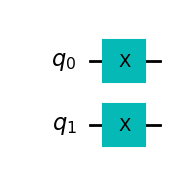

In [17]:
quantum_circuit = QuantumCircuit(qubits.value)

# --- Ab hier dein Code ---

for i in range(qubits.value):
    quantum_circuit.x(i)

# -------------------------

quantum_circuit.draw("mpl")

Beachte hierbei, dass wir aktuell die einzelnen Bits betrachten, aus denen ein einziger Wert des Bildes zusammengesetzt ist.
Unser Quanten Circuit muss also auf jedes Pixel und auf jeden Kanal (Rot, Grün, Blau) des Bildes angewandt werden.

Da unser Quanten Circuit aber jedesmal das gleiche ist, können wir uns die Abbildung (Mapping) der einzelnen Bits von dem Eingangs- auf den Ausgangswert einmal speichern und dann auf das gesamte Bild anwenden.
Das spart uns einiges an Rechenzeit auf dem Quantencomputer!

Genau das wird in den folgenden Zeilen gemacht. Zuerst erzeugen wir ein `Mapping` (hierbei wird der Quantencomputer genutzt) und anschliessend wenden wir dieses auf den Bildausschnit `pixels_to_transform` unseres Katzenbildes an.

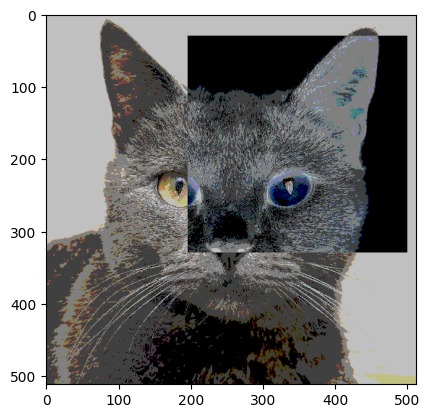

In [21]:
mapping = create_mapping(quantum_circuit)
q_image = convert_image(qubits.value, image, mapping, pixels_to_transform)
plt.imshow(q_image)

Perfekt! Welches Mapping haben wir denn jetzt mit dem Quantencomputer erzeugt? Das können wir und mit einer Funktion anzigen lassen, die wir für Dich geschrieben haben. Führe dafür mal die folgende Codezeile aus.

In [28]:
print_mapping(mapping)

00 wird auf 11 abgebildet
01 wird auf 10 abgebildet
10 wird auf 01 abgebildet
11 wird auf 00 abgebildet


Es wird also quasi aus jeder 0 eine 1 gemacht. Das passt ja: auf deinem Circuit befinden sich auf jedem Qubit ein `x` Gate, das den Wert ändert. 

Wahrscheinlich hast du es schon gemerkt, aber Qubits sind für einen Quantencomputer das, was Bits für unsere klassischen Computer sind; Die kleinste Informationseinheit die wir mit diesen Geräten abbilden können.
Das Spannende ist nun, mit so einem Qubit kann man viel mehr machen, als wir es mit einem klassischen Bit könnte!

Ein Qubit kann nicht nur entweder 0 oder 1 sein, sondern beides gleichzeitig mit einer gewissen Wahrscheinlichkeit. Klingt ein bisschen komisch?

Stell dir jetzt einfach vor, im klassischen haben wir nur einen Strich an dessen Endpunkten entweder `0` oder `1` steht. Genau diese und nur diese beide Zustände können wir einnehmen.
Im Quantencomputing haben wir nun für ein Qubit die Möglichkeit als Zustand jeden erdenklichen Punkt auf der Oberfläche einer Kugel einzunehmen. 

![Bit und Qubit Darstellung](images/qbits.png)


## Die zufällige Katze

Das Problem ist nun, dass wenn wir von dem Quantencomputer wieder auf unseren klassischen Computer gehen wollen, wir die Information irgendwie *messen* müssen. Das ist genau die Operation, die wir oben mit dem `measure_all()` erreicht haben.
Hierbei muss sich das Qubit nun entscheiden ob es entweder eine $0$ oder eine $1$ wird, je nachdem wie nah es sich an den beiden Punkten befindet.

**Aufgabe:** Was schätzt du denn, was passiert, wenn es sich genau in der Mitte, also auf dem Äquator der Kugel, befindet?

Schauen wir doch mal ob das stimmt. Im folgenden erzeugen wir ein Quantum Circuit auf das wir sogenannte `h` Gates anwenden. Die bringen uns von unserem Grundzustand nämlich genau auf den Äquator:

![Plus-State](images/plusstate.png)

In [30]:
quantum_circuit = QuantumCircuit(qubits.value)

# --- Ab hier dein Code ---

for i in range(qubits.value):
    quantum_circuit.h(i)

# -------------------------

quantum_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

Führe den folgenden Code einfach ein paar mal aus und beobachte wie sich das Mapping, bzw. das Bild verändert.

00 wird auf 11 abgebildet
01 wird auf 10 abgebildet
10 wird auf 10 abgebildet
11 wird auf 11 abgebildet


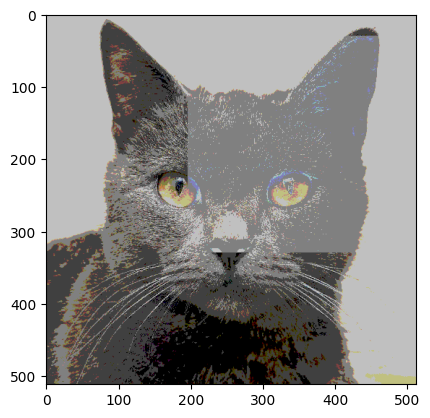

In [33]:
mapping = create_mapping(quantum_circuit)
q_image = convert_image(qubits.value, image, mapping, pixels_to_transform)

print_mapping(mapping)

plt.imshow(q_image)

Klasse! Jetzt weißt du ja schon, dass so ein Qubit mehr Zustände annehmen kann, als ein klassissches Bit.
Es gibt aber noch mehr! Bisher war immer die Rede von einem einzigen Qubit. Wir können im Quantencomputing aber auch zwei Qubits miteinander verschränken, so, dass wenn wir eins der beiden messen, das andere exakt den gleichen Zustand annehmen wird.
Das ist ein bisschen schwierig zu erklären, am Besten fragst du uns einfach wenn du mehr dazu wissen möchtest!



## Die vertauschte Katze

Wir können diese Verschränkung allerdings nutzen um den Zustand zweier Qubits zu tauschen und somit auch die Farben in unserem Bild.
Dazu erzeugen wir ein Quantumcircuit mit `3` mal so vielen Qubits wie wir bisher gebraucht haben, da wir nun alle `3` Farbkanäle abbilden wollen.
Anschliessend tauschen wir jeweils die Qubits der Rot (0,1)- und Grünkanäle (2,3).

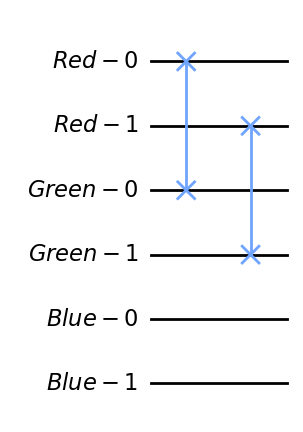

In [35]:
rgb_qubits = create_rgb_qubits(qubits.value)
quantum_circuit = QuantumCircuit(*rgb_qubits)

quantum_circuit.swap(0, 2)
quantum_circuit.swap(1, 3)

quantum_circuit.draw("mpl")

Jetzt wieder der Code um das Mapping zu erzeugen und es auf das Bild anzuwenden..
Spiele gerne ein wenig mit den Bits herum und schaue wie sich das Bild verändert.

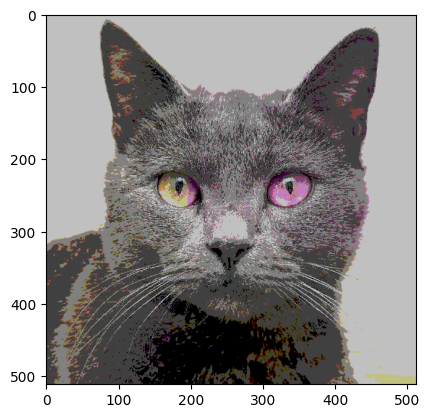

In [36]:
mapping = create_rgb_mapping(quantum_circuit)
q_image = convert_rgb_image(qubits.value, image, mapping, pixels_to_transform)
plt.imshow(q_image)

## Es geht auf den Quantencomputer

Zum Abschluss kannst du dir jetzt nochmal ein eigenes Circuit bauen (lass dich gerne von den vorherigen inspirieren) und dieses an einen echten Quantencomputer schicken!

In [ ]:
quantum_circuit = QuantumCircuit(3 * qubits.value)

# --- Ab hier dein Code ---


# -------------------------

quantum_circuit.draw()

Zuerst simulieren wir das ganze nochmal um sicherzugehen, dass es auch den Effekt erzielt den du haben möchtest.

In [ ]:
mapping = create_rgb_mapping(quantum_circuit)
q_image = convert_rgb_image(qubits, image, mapping, pixels_to_transform)

# print_mapping(mapping)

plt.imshow(q_image)

In [ ]:
# backend = "ibm_oslo" # 7 qubits
backend = None

mapping = create_rgb_mapping(quantum_circuit, backend=backend)
q_image = convert_rgb_image(qubits, image, mapping, pixels_to_transform)

# print_mapping(mapping)

plt.imshow(q_image)

In [ ]:
plt.imsave("./results/Cat.jpg", q_image)

## Die verrauschte Katze

**Zusatzmaterial**: Bisher liefen unsere Simulation und Berechnung in einer "idealen" Welt. Das heisst, wir hatten keine Störeinflüsse von außen und die Simulationen lieferten stets das Ergebnis, das wir mathematisch auch erwarten würden.
Nun sind so Quantencomputer heutzutage leider noch alles andere als perfekt. 
Um uns das mal genauer anzuschauen, lernst du hier noch eine weitere tolle Eigenschaft von Quantencomputern kennen. Jede Operation die wir auf einem solchen Gerät ausführen ist (bis auf die Messung am Ende) umkehrbar!
Das bedeutet, wir können das Circuit von gerade eben einfach nehmen, umdrehen (`inverse()`) und an das Original anhängen (`.compose()`).
Das Ergebnis sollte im Idealfall ein Circuit sein, das nichts an unserem Bild ändert.. , oder?

Der folgende Code macht genau das gerade beschriebene. Sicher erkennst du die einzelnen Teile des erzeugten Circuits wieder.

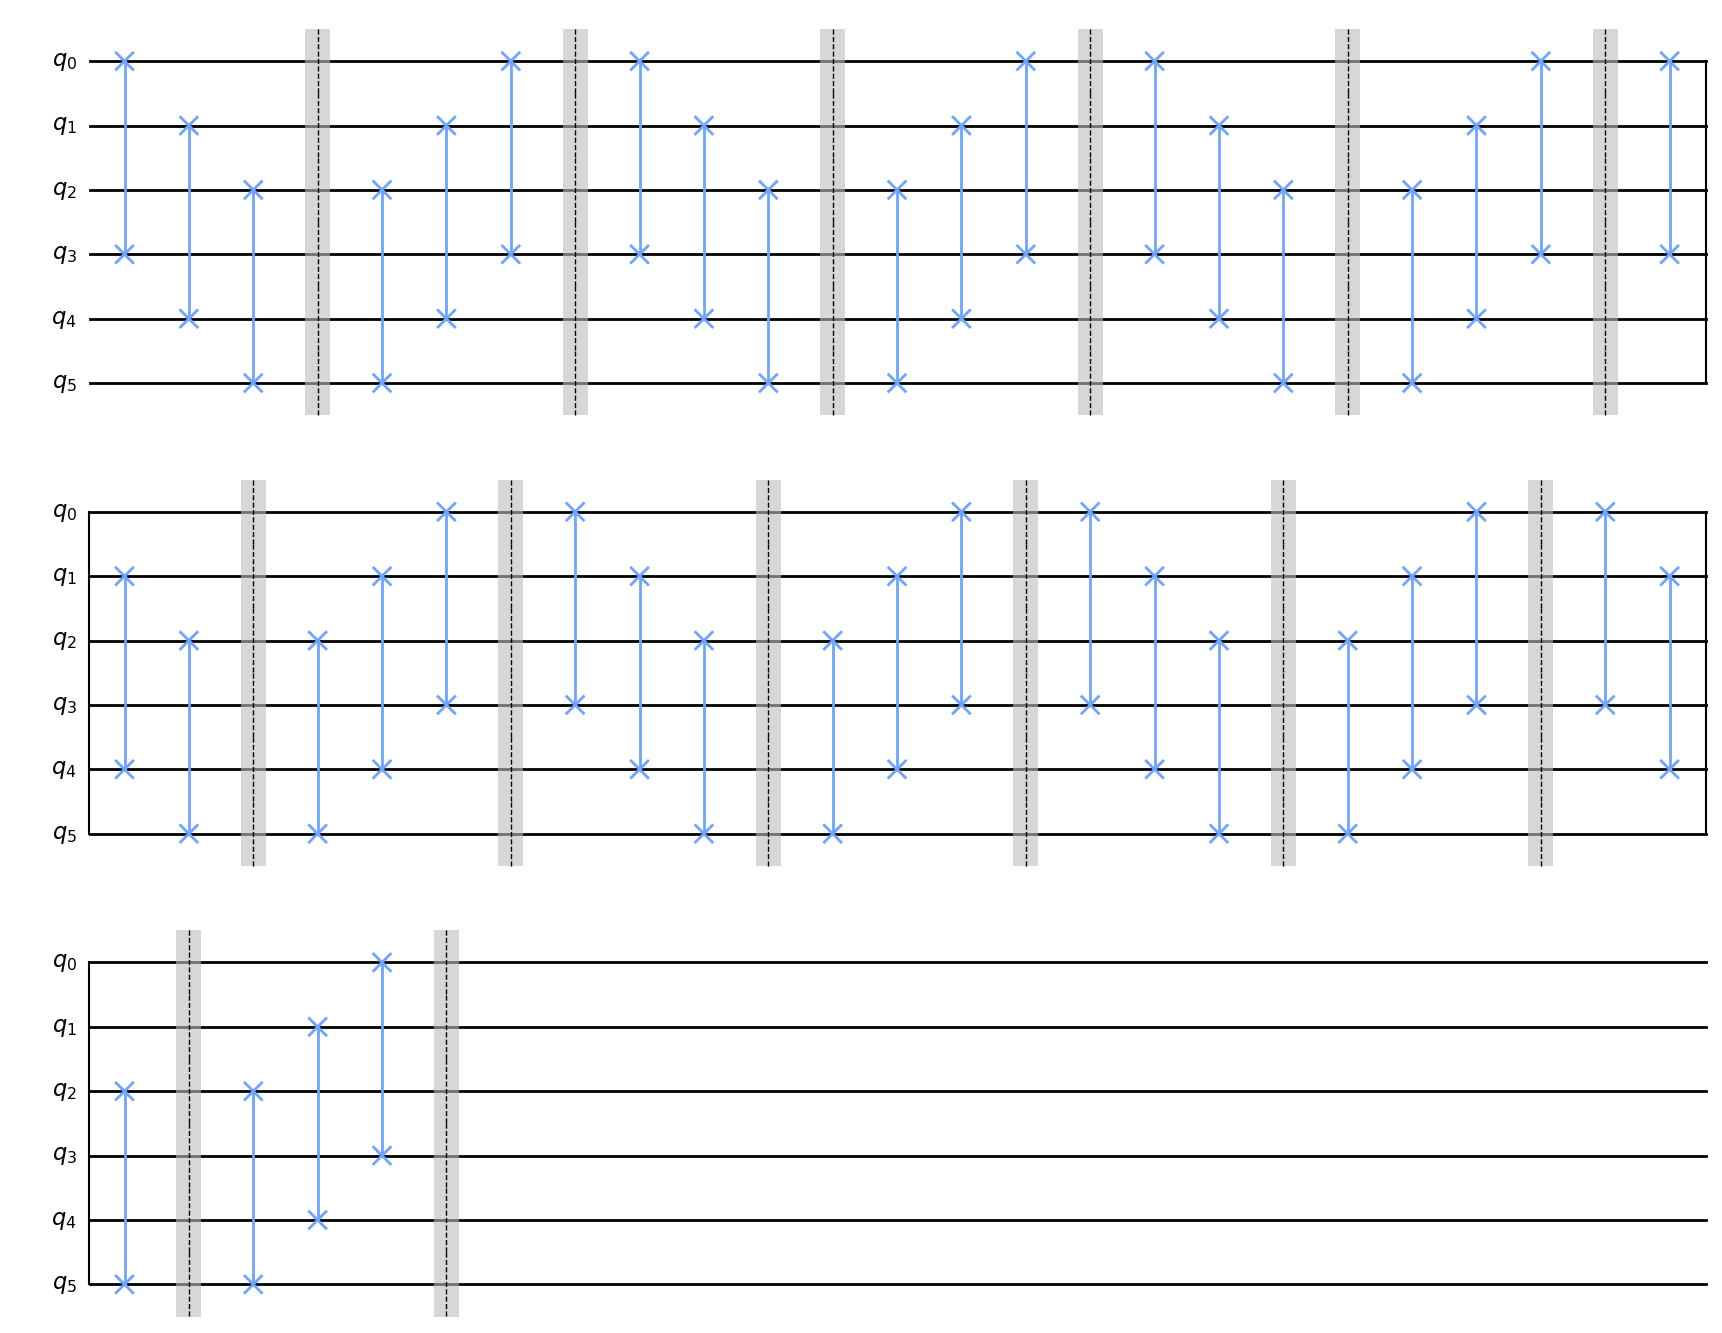

In [62]:
REPS = 7  # how often do you want to repeat your circuit ?

overall_quantum_circuit = QuantumCircuit(3 * qubits.value)

for i in range(REPS):
    overall_quantum_circuit.compose(quantum_circuit, inplace=True)
    overall_quantum_circuit.barrier()
    overall_quantum_circuit.compose(quantum_circuit.inverse(), inplace=True)
    overall_quantum_circuit.barrier()

overall_quantum_circuit.draw("mpl")

Nun führen wir wieder den bekannten Code zum erzeugen des Mappings und darstellen des Bildes aus, übergeben allerdings ein sogenanntes `backend` welches ein detailgetreues Modell eines echten Quantencomputers ist.
Dieses Modell wird in der Simulation dann verwendet um das Verhalten des echten Computers nachzubilden.

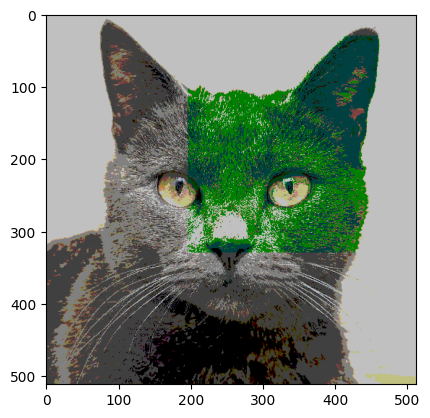

In [63]:
backend = FakeMelbourne()

mapping = create_rgb_mapping(overall_quantum_circuit, backend=backend)
q_image = convert_rgb_image(qubits.value, image, mapping, pixels_to_transform)

# print_mapping(mapping)

plt.imshow(q_image)

Huch! Da ist wohl was schiefgegangen, oder?
Nein, leider nicht. Die Quantencomputer sind in der Tat sehr Fehleranfällig heutzutage.

Aber Zeiten ändern sich! Die Leute von IBM, deren Maschinen wir heute nutzen, und viele andere Forscher auf der Welt versuchen Quantencomputer so schnell wie möglich fehlerfrei und vor allem größer zu bauen.

